In [ ]:
%%capture
%pip install -r ../requirements.txt

In [5]:
from schema import WLD

wld = WLD(file_path="../data/example-chappy.wld")

In [6]:
# Get all exercises from all workouts
all_exercises = []
for workout in wld.workouts:
    all_exercises.extend(workout.exercises)
print(f"Total exercises: {len(all_exercises)}")

Total exercises: 8821


In [35]:
from collections import Counter

favorite_exercises = [
    "70 degree incline press",
    "Flat Barbell Bench Press",
    "Flat Barbell Bench Press GVT", # calculated later
    "Incline Barbell Bench Press",
    "T-Bar Bent Rows",
    "Close-grip Bench Press",
    "Barbell Conventional Curls",
    "Deadlifts",
    "Normal Lat Pulldowns",
    # "Low Leg Press",
    "One-arm Overhead Extensions",
    "Barbell Overhead Press",
    "Barbell Preacher Curls",
    "Back Squats",
]

# Count exercise names and iterations, only for reps_weight exercises
exercise_counts = Counter()
for exercise in all_exercises:
    key = exercise.displayName()
    # Special case to combine deadlift iterations
    if key == "Conventional Deadlifts" or key == "Sumo Deadlifts":
        key = "Deadlifts"
    if key in favorite_exercises:
        exercise_counts[key] += 1

percent_of_total = (sum(exercise_counts.values()) / len(all_exercises)) * 100

print(f"Counts of favorite exercises (representing {sum(exercise_counts.values()):,} exercises, {percent_of_total:.1f}% of total):")
for i, (name, count) in enumerate(exercise_counts.most_common(), 1):
    print(f"{i}. {name}: {count:,} times")

Counts of favorite exercises (representing 2,188 exercises, 24.8% of total):
1. Flat Barbell Bench Press: 369 times
2. One-arm Overhead Extensions: 296 times
3. Close-grip Bench Press: 268 times
4. Barbell Overhead Press: 259 times
5. Back Squats: 183 times
6. Barbell Preacher Curls: 180 times
7. Incline Barbell Bench Press: 162 times
8. Barbell Conventional Curls: 151 times
9. Normal Lat Pulldowns: 123 times
10. Deadlifts: 90 times
11. T-Bar Bent Rows: 59 times
12. 70 degree incline press: 48 times


In [37]:
# Sort all exercises by date before processing PRs
all_exercises.sort(key=lambda x: x.workout().date)

current_one_rms = {}
current_volumes = {}

all_one_rm_prs = []
all_volume_prs = []

for exercise in all_exercises:
    key = exercise.displayName()
    # Special case to combine deadlift iterations
    if key == "Conventional Deadlifts" or key == "Sumo Deadlifts":
        key = "Deadlifts"
    if key not in favorite_exercises:
        continue
    one_rm = max([set.oneRM for set in exercise.sets])
    volume = sum([set.volume for set in exercise.sets])
    date = exercise.workout().date
    if one_rm > current_one_rms.get(key, 0):
        if key in current_one_rms:
            all_one_rm_prs.append((date, key, one_rm))
        current_one_rms[key] = one_rm
    if volume > current_volumes.get(key, 0):
        if key in current_volumes:
            all_volume_prs.append((date, key, volume))
        current_volumes[key] = volume

    # Special case to track GVT PRs
    if key == "Flat Barbell Bench Press" and len(exercise.sets) >= 10:
        # Find sequences of 10+ consecutive sets with 10+ reps at the same weight
        current_weight = 0
        current_streak = 0
        max_gvt_weight = 0

        for set in exercise.sets:
            if set.reps >= 10 and set.weight >= current_weight:
                current_streak += 1
                current_weight = set.weight
            else:
                current_streak = 0
                current_weight = 0

            if current_streak >= 10:
                max_gvt_weight = max(max_gvt_weight, current_weight)

        # Record GVT PR if we found a new max weight
        if max_gvt_weight > current_one_rms.get(key + " GVT", 0):
            if key + " GVT" in current_one_rms:
                all_one_rm_prs.append((date, key + " GVT", max_gvt_weight))
                all_volume_prs.append((date, key + " GVT", max_gvt_weight * 10))
            current_one_rms[key + " GVT"] = max_gvt_weight
            current_volumes[key + " GVT"] = max_gvt_weight * 10


print(f"Total 1RM PRs recorded: {len(all_one_rm_prs):,}")
print(f"Total volume PRs recorded: {len(all_volume_prs):,}")

Total 1RM PRs recorded: 226
Total volume PRs recorded: 181


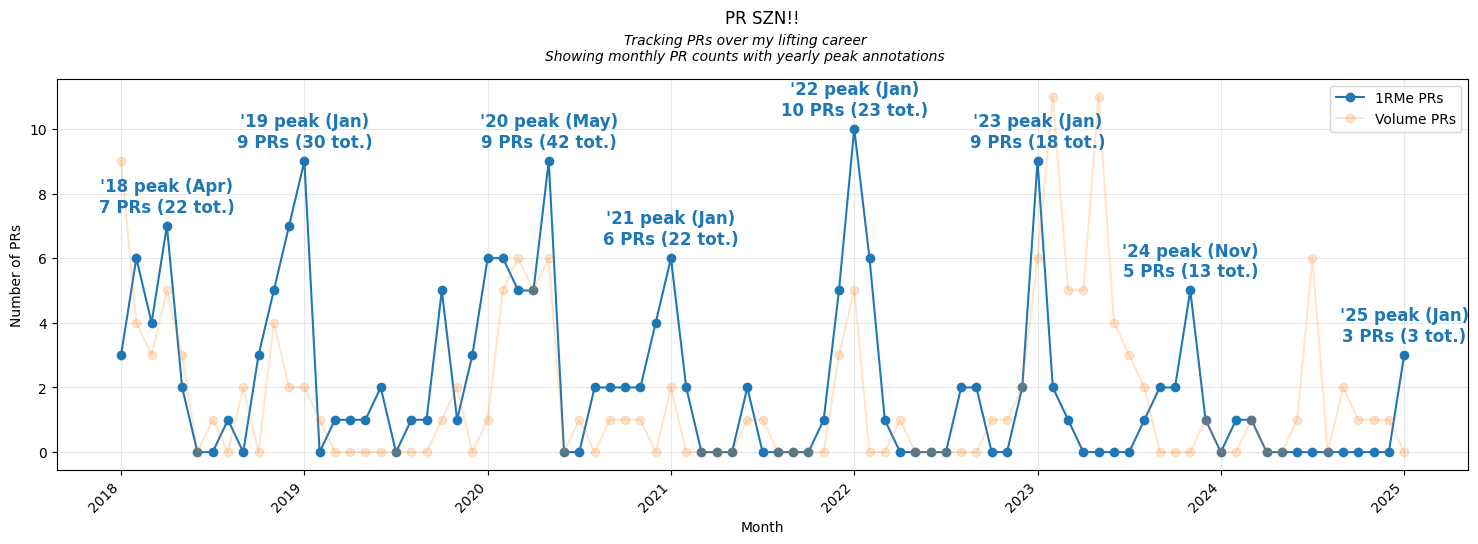

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from datetime import datetime

# Create dictionaries to store PR counts by month
one_rm_prs_by_month = defaultdict(int)
volume_prs_by_month = defaultdict(int)

# Convert dates to month keys and count PRs
for date, _, _ in all_one_rm_prs:
    if date.year < 2018:
        continue
    month_key = date.strftime("%Y-%m")
    one_rm_prs_by_month[month_key] += 1

for date, _, _ in all_volume_prs:
    if date.year < 2018:
        continue
    month_key = date.strftime("%Y-%m")
    volume_prs_by_month[month_key] += 1

# Generate all months between min and max dates
start_date = datetime(2018, 1, 1)
end_date = datetime.now()
all_months = pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m").tolist()

# Create lists for plotting
months = all_months
one_rm_counts = [one_rm_prs_by_month[month] for month in all_months]
volume_counts = [volume_prs_by_month[month] for month in all_months]

# Create the plot
plt.figure(figsize=(15, 6))

# Plot original lines
line1, = plt.plot(all_months, one_rm_counts, label="1RMe PRs", marker='o', alpha=1.0)
line2, = plt.plot(all_months, volume_counts, label="Volume PRs", marker='o', alpha=0.2)

# Calculate 3-month rolling averages
window_size = 3
one_rm_rolling = pd.Series(one_rm_counts).rolling(window=window_size).mean()
volume_rolling = pd.Series(volume_counts).rolling(window=window_size).mean()

# Plot rolling averages with reduced opacity
# plt.plot(all_months, one_rm_rolling, label="1RM PRs (3-month avg)", linewidth=2, color=line1.get_color(), alpha=0.2)
# plt.plot(all_months, volume_rolling, label="Volume PRs (3-month avg)", linewidth=2, color=line2.get_color(), alpha=0.2)

# Add peak labels for 6 months before and after Jan 1st of each year
for year in range(2018, datetime.now().year + 1):
    # Create mask for 6 months before and after Jan 1st
    year_start = f"{year}-01"
    prev_year = f"{year-1}-07"
    next_year = f"{year}-06"

    year_mask = []
    for month in all_months:
        is_in_range = prev_year <= month <= next_year
        year_mask.append(is_in_range)

    if any(year_mask):
        # Find peaks for 1RM PRs in the 12-month window
        year_1rm = [c if m else 0 for c, m in zip(one_rm_counts, year_mask)]
        year_total = sum(c1 for (c1, _, m) in zip(one_rm_counts, volume_counts, year_mask) if m)
        max_1rm = max(year_1rm)
        if max_1rm > 0:
            max_idx = year_1rm.index(max_1rm)
            peak_month = datetime.strptime(all_months[max_idx].split('-')[1], '%m').strftime('%b')
            plt.annotate(f'\'{year - 2000} peak ({peak_month})\n{max_1rm} PRs ({year_total} tot.)',
                        xy=(max_idx, max_1rm),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center',
                        color=line1.get_color(),
                        weight='bold',
                        fontsize=12)

        # # Find peaks for Volume PRs in the 12-month window
        # year_vol = [c if m else 0 for c, m in zip(volume_counts, year_mask)]
        # max_vol = max(year_vol)
        # if max_vol > 0:
        #     max_idx = year_vol.index(max_vol)
        #     plt.annotate(f'{max_vol}',
        #                 xy=(max_idx, max_vol),
        #                 xytext=(0, 10),
        #                 textcoords='offset points',
        #                 ha='center',
        #                 color=line2.get_color())

# Customize the plot
plt.title("PR SZN!!", pad=40)
plt.suptitle("Tracking PRs over my lifting career\nShowing monthly PR counts with yearly peak annotations", y=.86, fontsize=10, style='italic')
plt.xlabel("Month")
plt.ylabel("Number of PRs")

# Show x-axis labels for Jan 1 of each year
tick_positions = []
tick_labels = []
for i, month in enumerate(months):
    year, month = month.split('-')
    if month == '01':  # January only
        tick_positions.append(i)
        tick_labels.append(f"{year}")

plt.xticks(tick_positions, tick_labels, rotation=45, ha="right")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
running_one_rms = {}
all_agg_one_rms = []

for pr in all_one_rm_prs:
  running_one_rms[pr[1]] = pr[2]
  if len(running_one_rms) == len(favorite_exercises):
    all_agg_one_rms.append((pr[0], sum(running_one_rms.values())))

print(len(all_agg_one_rms))


171


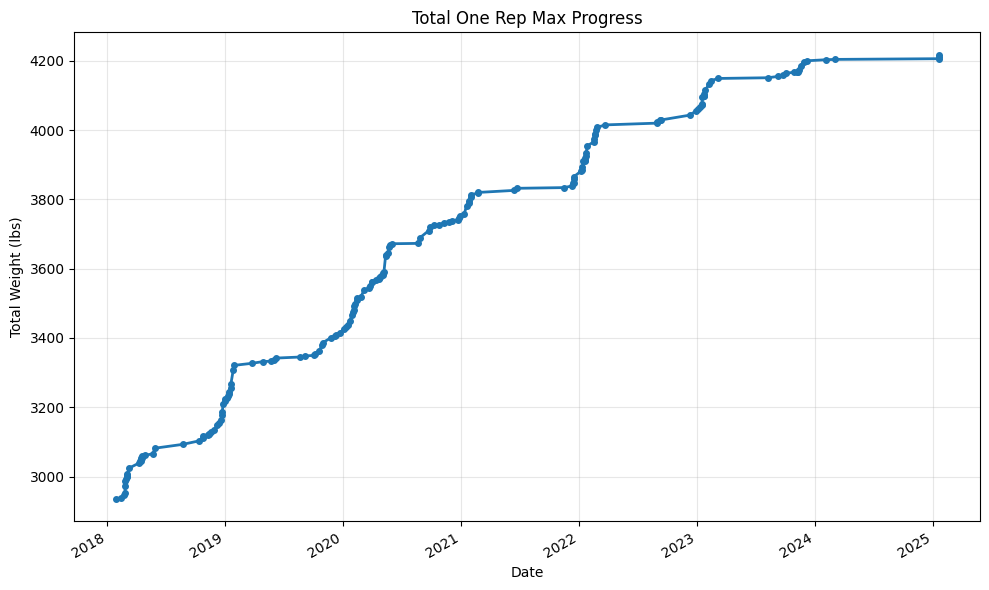

In [22]:
# Extract dates and values from all_agg_one_rms
dates = [x[0] for x in all_agg_one_rms]
total_weights = [x[1] for x in all_agg_one_rms]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(dates, total_weights, marker='o', linestyle='-', linewidth=2, markersize=4)

# Customize the plot
plt.title("Total One Rep Max Progress")
plt.xlabel("Date")
plt.ylabel("Total Weight (lbs)")

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()  # Angle and align the tick labels so they look better

# Add grid
plt.grid(True, alpha=0.3)

# Use tight layout
plt.tight_layout()

# Show the plot
plt.show()


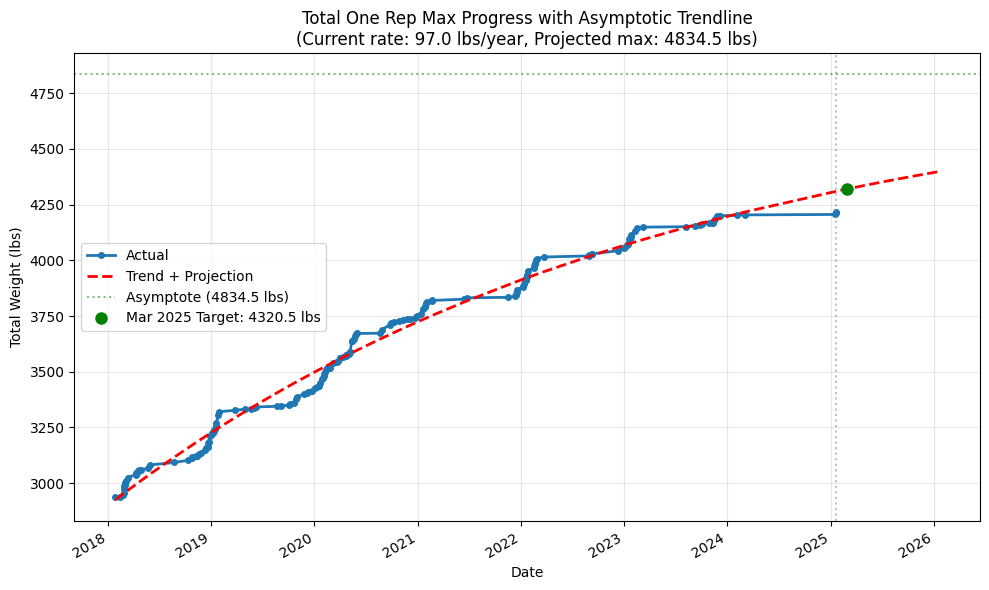

Current total weight as of 2025-01-19: 4218.0 lbs


In [31]:
import numpy as np
from matplotlib.dates import date2num
from datetime import timedelta, datetime

# Define asymptotic function (y = a - b*e^(-cx))
def asymptotic_func(x, a, b, c):
    return a - b * np.exp(-c * x)

# Convert dates to numeric values for trendline calculation
date_nums = date2num(dates)

# Normalize dates to start from 0 for better fitting
min_date_num = min(date_nums)
normalized_dates = date_nums - min_date_num

# Fit asymptotic curve
from scipy.optimize import curve_fit
popt, _ = curve_fit(
    asymptotic_func,
    normalized_dates,
    total_weights,
    p0=[max(total_weights)*1.1, 1500, 0.001],  # Initial guesses
    bounds=([max(total_weights), 0, 0], [max(total_weights)*1.5, 3000, 0.01])
)

# Create future dates for projection
future_dates = dates + [dates[-1] + timedelta(days=x) for x in range(1, 366)]
future_date_nums = date2num(future_dates)
normalized_future_dates = future_date_nums - min_date_num

# Calculate trendline including projection
trendline = asymptotic_func(normalized_future_dates, *popt)

# Calculate current rate of change (at the last point)
def asymptotic_derivative(x, a, b, c):
    return b * c * np.exp(-c * x)

current_rate = asymptotic_derivative(normalized_dates[-1], *popt) * 365  # Convert to yearly rate

# Calculate March 1st, 2025 target
target_date = datetime(2025, 3, 1)
target_date_num = date2num(target_date)
normalized_target_date = target_date_num - min_date_num
target_weight = asymptotic_func(normalized_target_date, *popt)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(
    dates,
    total_weights,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=4,
    label="Actual",
)

# Plot trendline with projection
plt.plot(future_dates, trendline, "r--", linewidth=2, label="Trend + Projection")

# Add vertical line separating actual from projected
plt.axvline(x=dates[-1], color='gray', linestyle=':', alpha=0.5)

# Add horizontal line showing asymptote
plt.axhline(y=popt[0], color='green', linestyle=':', alpha=0.5, label=f'Asymptote ({popt[0]:.1f} lbs)')

# Add target point
plt.plot(target_date, target_weight, 'go', markersize=8, label=f'Mar 2025 Target: {target_weight:.1f} lbs')

plt.title(
    f"Total One Rep Max Progress with Asymptotic Trendline\n"
    f"(Current rate: {current_rate:.1f} lbs/year, Projected max: {popt[0]:.1f} lbs)"
)

plt.xlabel("Date")
plt.ylabel("Total Weight (lbs)")
plt.legend()

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

# Add grid
plt.grid(True, alpha=0.3)

# Use tight layout
plt.tight_layout()

# Show the plot
plt.show()

print(
    f"Current total weight as of {dates[-1].strftime('%Y-%m-%d')}: {total_weights[-1]:.1f} lbs"
)

In [13]:
favorite_exercise_weights = {
    "70 degree incline press": 0.03,
    "Flat Barbell Bench Press": 0.15,
    "Flat Barbell Bench Press GVT": 0.03,
    "Incline Barbell Bench Press": 0.02,
    "T-Bar Bent Rows": 0.08,
    "Close-grip Bench Press": 0.07,
    "Barbell Conventional Curls": 0.03,
    "Deadlifts": 0.15,
    "Normal Lat Pulldowns": 0.07,
    "One-arm Overhead Extensions": 0.03,
    "Barbell Overhead Press": 0.12,
    "Barbell Preacher Curls": 0.07,
    "Back Squats": 0.15,
}

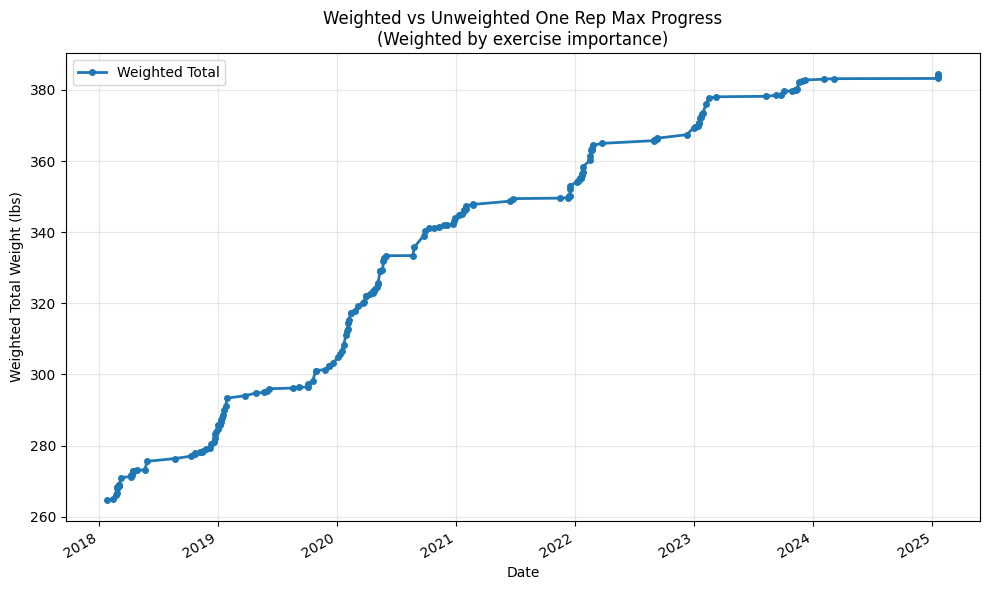

NameError: name 'current_date' is not defined

In [30]:
# Calculate weighted running 1RMs
weighted_running_one_rms = {}
all_weighted_agg_one_rms = []

for pr in all_one_rm_prs:
    exercise = pr[1]
    weight = favorite_exercise_weights.get(exercise, 0)
    weighted_running_one_rms[exercise] = pr[2] * weight
    if len(weighted_running_one_rms) == len(favorite_exercises):
        all_weighted_agg_one_rms.append((pr[0], sum(weighted_running_one_rms.values())))

# Extract dates and values
weighted_dates = [x[0] for x in all_weighted_agg_one_rms]
weighted_totals = [x[1] for x in all_weighted_agg_one_rms]

# Create the plot with both weighted and unweighted data
plt.figure(figsize=(10, 6))

# Plot weighted data
plt.plot(
    weighted_dates,
    weighted_totals,
    marker="o",
    linestyle="-",
    label="Weighted Total",
    linewidth=2,
    markersize=4,
)

# Customize the plot
plt.title(
    "Weighted vs Unweighted One Rep Max Progress\n(Weighted by exercise importance)"
)
plt.xlabel("Date")
plt.ylabel("Weighted Total Weight (lbs)")
plt.legend()

# Format x-axis
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()